In [7]:
import numpy as np
from scipy.optimize import minimize, approx_fprime

# Fake dataset
np.random.seed(42)
X = np.random.randn(10_000, 2)
beta_true = np.array([1.0, -2.0])
p = 1 / (1 + np.exp(-(X @ beta_true)))
y = np.random.binomial(1, p)

# BCE loss function (negative log-likelihood)
def bce_loss(beta):
    z = X @ beta
    p_hat = 1 / (1 + np.exp(-z))
    eps = 1e-9
    return -np.sum(y * np.log(p_hat + eps) + (1 - y) * np.log(1 - p_hat + eps))

# Fit the model
res = minimize(bce_loss, x0=np.zeros(X.shape[1]), method="BFGS")
beta_hat = res.x
print("beta_hat:", beta_hat)


beta_hat: [ 1.06445722 -2.07456039]


In [8]:
def numerical_hessian(fun, x0, epsilon=1e-6):
    n = len(x0)
    H = np.zeros((n, n))
    for i in range(n):
        x_i_up = x0.copy()
        x_i_down = x0.copy()
        x_i_up[i] += epsilon
        x_i_down[i] -= epsilon

        grad_i_up = approx_fprime(x_i_up, fun, epsilon)
        grad_i_down = approx_fprime(x_i_down, fun, epsilon)

        H[:, i] = (grad_i_up - grad_i_down) / (2 * epsilon)
    return H


In [9]:
def hessian_logistic(beta):
    p_hat = 1 / (1 + np.exp(-(X @ beta)))
    w = p_hat * (1 - p_hat)                # N vector
    X_weighted = X * w[:, None]            # N x k
    return X.T @ X_weighted                 # k x k


In [10]:
# Hessian at beta_hat
H = numerical_hessian(bce_loss, beta_hat)

# Covariance matrix = inverse Hessian
cov_matrix = np.linalg.inv(H)
se = np.sqrt(np.diag(cov_matrix))

# 95% CI
z = 1.96
ci_lower = beta_hat - z * se
ci_upper = beta_hat + z * se

print("Standard errors:", se)
print("95% CI lower:", ci_lower)
print("95% CI upper:", ci_upper)


Standard errors: [0.03181739 0.04345654]
95% CI lower: [ 1.00209513 -2.1597352 ]
95% CI upper: [ 1.12681931 -1.98938557]


In [15]:
def se_ci_from_hessian(H, beta_hat, z=1.96):
    cov_matrix = np.linalg.inv(H)
    se = np.sqrt(np.diag(cov_matrix))
    ci_lower = beta_hat - z * se
    ci_upper = beta_hat + z * se
    return se, ci_lower, ci_upper

In [12]:
H = hessian_logistic(beta_hat)
cov_matrix = np.linalg.inv(H)
se = np.sqrt(np.diag(cov_matrix))

# 95% CI
z = 1.96
ci_lower = beta_hat - z * se
ci_upper = beta_hat + z * se

print("Standard errors:", se)
print("95% CI lower:", ci_lower)
print("95% CI upper:", ci_upper)


Standard errors: [0.03180573 0.04342601]
95% CI lower: [ 1.00211799 -2.15967536]
95% CI upper: [ 1.12679644 -1.98944541]


## Linear Product Regressor, MSE Loss, SE Estimation

In [7]:
from quantbullet.linear_product_model._test_utils import generate_linear_product_example_data, plot_predictions_by_bins
from quantbullet.linear_product_model import LinearProductRegressorScipy

In [18]:
import numpy as np
from scipy.optimize import approx_fprime

df, train_df, feature_groups = generate_linear_product_example_data( n_samples=1_000 )
lpr_scipy = LinearProductRegressorScipy()

In [19]:
lpr_scipy.fit(train_df, df['y'], feature_groups=feature_groups)

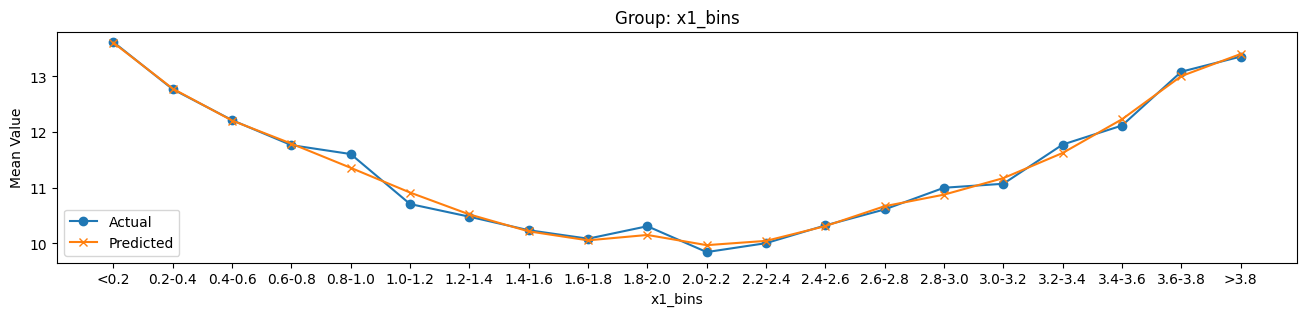

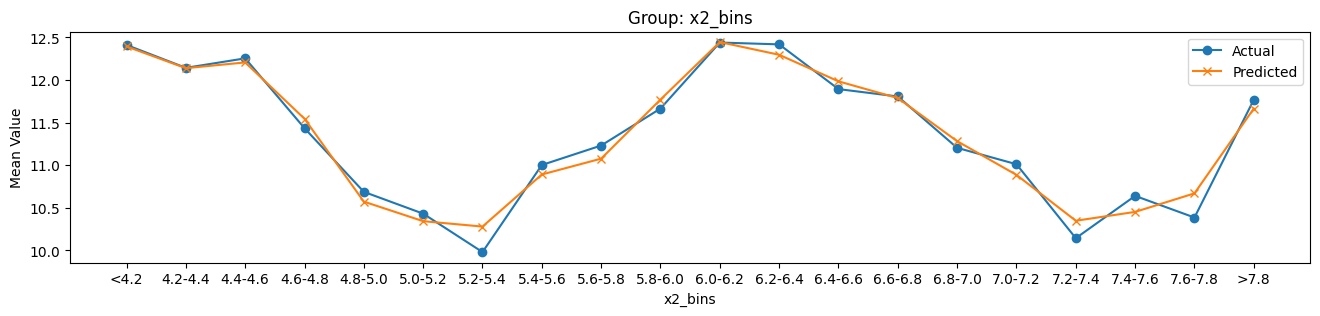

In [20]:
df['clf_scipy_pred'] = lpr_scipy.predict(train_df)
plot_predictions_by_bins(df, true_col='y', pred_col='clf_scipy_pred')

In [35]:
lpr_scipy.calculate_se(train_df, df['y'])

{'x1': array([0.30422187, 0.10805546, 0.08629726, 0.08708575, 0.08562279,
        0.08599932, 0.0871483 , 0.09221466, 0.11852378]),
 'x2': array([0.98471121, 0.17415688, 0.1400852 , 0.140393  , 0.14036821,
        0.1318363 , 0.12951809, 0.13320722, 0.15679909])}

In [36]:
lpr_scipy.summary()

,feature_group,feature_name,coefficient,standard_error,ci_lower,ci_upper
0,x1,x1_bias,1.4842,0.3042,0.8880,2.0805
1,x1,x1_le_0.5,1.0005,0.1081,0.7887,1.2123
2,x1,x1_0.5_1.0,0.4316,0.0863,0.2625,0.6008
3,x1,x1_1.0_1.5,0.4504,0.0871,0.2797,0.6211
4,x1,x1_1.5_2.0,0.1095,0.0856,-0.0583,0.2774
5,x1,x1_2.0_2.5,-0.1066,0.0860,-0.2751,0.0620
6,x1,x1_2.5_3.0,-0.3848,0.0871,-0.5556,-0.2140
7,x1,x1_3.0_3.5,-0.5687,0.0922,-0.7494,-0.3880
8,x1,x1_gt_3.5,-0.8031,0.1185,-1.0354,-0.5708
9,x2,x2_bias,-3.7754,0.9847,-5.7054,-1.8454


## Appendix

In [100]:
def mse_loss(beta, model):
    model.coef_ = model.unflatten_params(beta)
    y_hat = model.predict(train_df)
    return 0.5 * np.sum((y_hat - df['y']) ** 2)

def numerical_hessian(fun, beta, eps=1e-3, model=None):
    n = len(beta)
    H = np.zeros((n, n))
    for i in range(n):
        beta_up = beta.copy()
        beta_dn = beta.copy()
        beta_up[i] += eps
        beta_dn[i] -= eps
        grad_up = approx_fprime(beta_up, fun, eps, model)
        grad_dn = approx_fprime(beta_dn, fun, eps, model)
        H[:, i] = (grad_up - grad_dn) / (2 * eps)
    return H

In [101]:
H_num = numerical_hessian(mse_loss, lpr_scipy.coef_vector, model=lpr_scipy)

In [102]:
se_ci_from_hessian(H_num, lpr_scipy.coef_vector)

(array([0.29384063, 0.12370254, 0.08972303, 0.09245817, 0.08749206,
        0.0879432 , 0.09204898, 0.10058432, 0.11477694, 1.20407584,
        0.18044919, 0.15196848, 0.14372498, 0.15872819, 0.13555775,
        0.14507561, 0.13206314, 0.10503872]),
 array([ 0.90830183,  0.75806326,  0.25577061,  0.26914607, -0.06193796,
        -0.27893214, -0.56522374, -0.76585202, -1.02809324, -6.13538108,
        -0.23857787,  1.11313451, -0.44206702, -1.64104837, -0.22143043,
         0.76789367,  0.2020476 , -1.51271257]),
 array([ 2.06015711,  1.24297723,  0.60748488,  0.6315821 ,  0.28103091,
         0.06580519, -0.20439174, -0.37156148, -0.57816762, -1.41540379,
         0.46878297,  1.70885093,  0.12133489, -1.01883386,  0.30995597,
         1.33659008,  0.71973512, -1.10096079]))